# **STEP 1: Import & Load Data**

In [ ]:
# =================================================================
# STEP 1: โหลด/import Dataset
# =================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import learning_curve
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from google.colab import files

# อัปโหลดไฟล์
uploaded = files.upload()
df = pd.read_csv(list(uploaded.keys())[0])

Saving train.csv to train.csv


# **STEP 2: ตรวจสอบโครงสร้างข้อมูล**
#**(ตรวจสอบจำนวนแถว–คอลัมน์ ชนิดข้อมูล และระบุตัวแปรเป้าหมาย)**

In [ ]:
# =================================================================
# STEP 2: ตรวจสอบโครงสร้างข้อมูล
# =================================================================

print(f"Shape ของข้อมูล: {df.shape}")
print(df.head(10))
df.info()
target_col = 'TARGET(PRICE_IN_LACS)'

Shape ของข้อมูล: (29451, 12)
  POSTED_BY  UNDER_CONSTRUCTION  RERA  BHK_NO. BHK_OR_RK    SQUARE_FT  \
0     Owner                   0     0        2       BHK  1300.236407   
1    Dealer                   0     0        2       BHK  1275.000000   
2     Owner                   0     0        2       BHK   933.159722   
3     Owner                   0     1        2       BHK   929.921143   
4    Dealer                   1     0        2       BHK   999.009247   
5     Owner                   0     0        3       BHK  1250.000000   
6    Dealer                   0     0        3       BHK  1495.053957   
7     Owner                   0     1        3       BHK  1181.012946   
8    Dealer                   0     1        2       BHK  1040.000000   
9     Owner                   0     1        2       BHK   879.120879   

   READY_TO_MOVE  RESALE                      ADDRESS  LONGITUDE   LATITUDE  \
0              1       1        Ksfc Layout,Bangalore  12.969910  77.597960   
1        

# **STEP 3: วิเคราะห์ Distribution + Outlier**
#**(วิเคราะห์การกระจายของราคาบ้านและตรวจสอบค่าผิดปกติในข้อมูล)**

--- สรุปผลการ Clean ข้อมูล ---
จำนวนแถวเดิม: 29,451 แถว
จำนวนแถวที่ถูกลบ (Outliers): 295 แถว
จำนวนแถวคงเหลือ: 29,156 แถว
ราคาเฉลี่ยเปลี่ยนจาก: 142.90 -> 92.93 Lacs
----------------------------------------


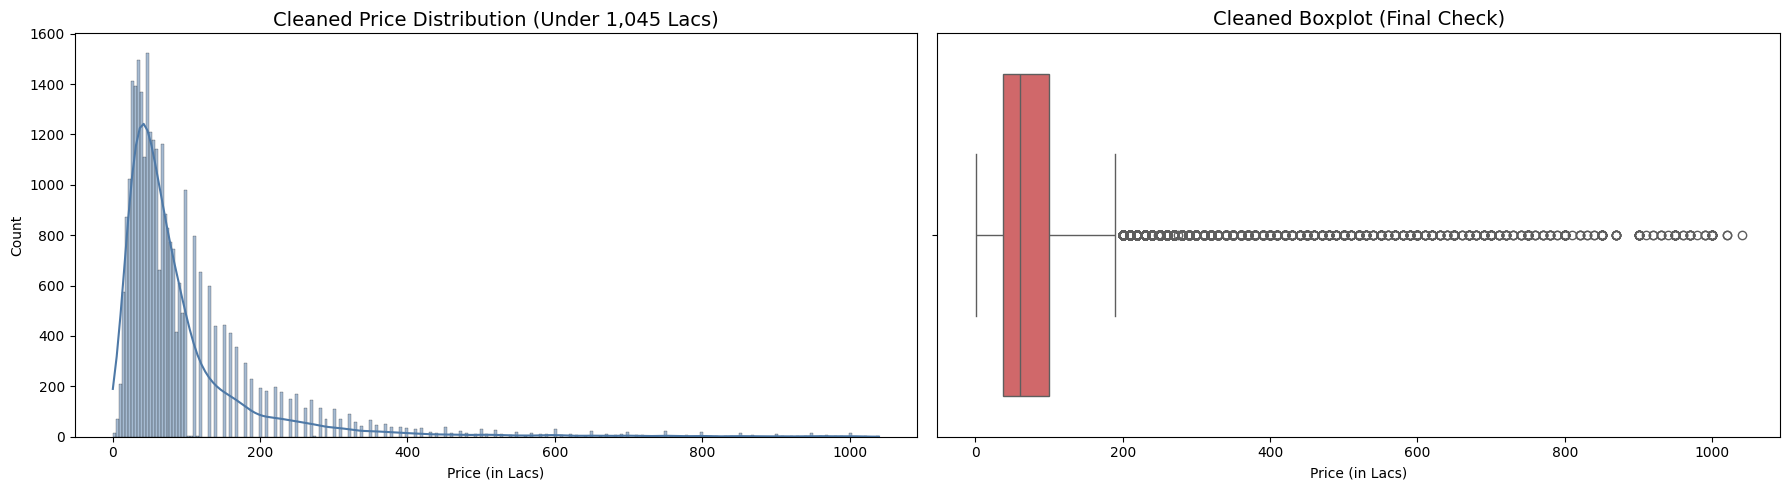

In [ ]:
  # =================================================================
  # STEP 3.1: การ Clean ข้อมูลและตรวจสอบผลลัพธ์ (Post-Cleaning)
  # =================================================================

  # Calculate q_high (99th Percentile) for outlier removal
  q_high = df[target_col].quantile(0.99)

  # --- 1. ขั้นตอนการ Clean ข้อมูล ---
  # กรองข้อมูลที่น้อยกว่า 99th Percentile (q_high จาก Cell ก่อนหน้า)
  df_cleaned = df[df[target_col] < q_high].copy()

  # --- 2. แสดงผลลัพธ์เชิงสถิติ ---
  print(f"--- สรุปผลการ Clean ข้อมูล ---")
  print(f"จำนวนแถวเดิม: {len(df):,} แถว")
  print(f"จำนวนแถวที่ถูกลบ (Outliers): {len(df) - len(df_cleaned):,} แถว")
  print(f"จำนวนแถวคงเหลือ: {len(df_cleaned):,} แถว")
  print(f"ราคาเฉลี่ยเปลี่ยนจาก: {df[target_col].mean():,.2f} -> {df_cleaned[target_col].mean():,.2f} Lacs")
  print("-" * 40)

  # --- 3. ตรวจสอบผลด้วยกราฟ (ใช้สีและสไตล์เดิมเพื่อเปรียบเทียบ) ---
  fig, ax = plt.subplots(1, 2, figsize=(18, 5))

  # Histogram หลัง Clean: จะเห็นการกระจายตัวของข้อมูลส่วนใหญ่ได้ละเอียดขึ้น
  sns.histplot(df_cleaned[target_col], kde=True, ax=ax[0], color='#4e79a7')
  ax[0].set_title(f'Cleaned Price Distribution (Under {q_high:,.0f} Lacs)', fontsize=14)
  ax[0].set_xlabel('Price (in Lacs)')

  # Boxplot หลัง Clean: จุด Outlier จะลดลงอย่างชัดเจนเมื่อเทียบกับกราฟก่อนหน้า
  sns.boxplot(x=df_cleaned[target_col], ax=ax[1], color='#e15759')
  ax[1].set_title('Cleaned Boxplot (Final Check)', fontsize=14)
  ax[1].set_xlabel('Price (in Lacs)')

  plt.tight_layout()
  plt.show()

# **STEP 4: วิเคราะห์ Correlation(วิเคราะห์ความสัมพันธ์ระหว่างตัวแปรอิสระกับราคาบ้าน)**

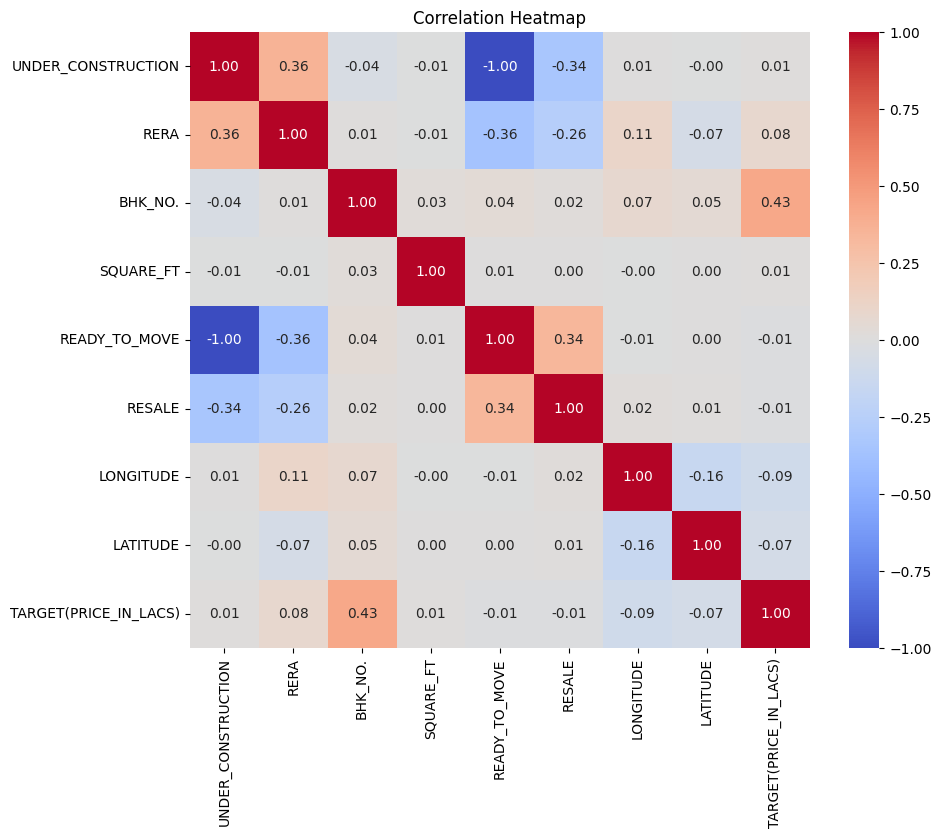

In [ ]:
# =================================================================
# STEP 4: วิเคราะห์ Correlation
# =================================================================

plt.figure(figsize=(10, 8))
numeric_cols = df_cleaned.select_dtypes(include=[np.number]).columns
sns.heatmap(df_cleaned[numeric_cols].corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Correlation Heatmap")
plt.show()

# **STEP 5: Preprocessing(เตรียมข้อมูลให้เหมาะสมกับโมเดล**
#**เช่น ลบ feature ที่ไม่จำเป็น และแปลงข้อมูลเชิงหมวดหมู่เป็นตัวเลข)**

In [ ]:
# =================================================================
# STEP 5: Preprocessing
# =================================================================

# ตัด ADDRESS และแปลงหมวดหมู่เป็นตัวเลข
df_final = df_cleaned.drop(columns=['ADDRESS'])
df_final = pd.get_dummies(df_final, columns=['POSTED_BY', 'BHK_OR_RK'], drop_first=True)

print(f"จำนวน Features หลังทำ One-Hot Encoding: {len(df_final.columns)}")

จำนวน Features หลังทำ One-Hot Encoding: 12


# **STEP 6: Train/Test Split(แบ่งข้อมูลสำหรับฝึกโมเดลและทดสอบโมเดลเพื่อป้องกัน Overfitting)**

In [ ]:
# =================================================================
# STEP 6: Train/Test Split
# =================================================================

X = df_final.drop(columns=[target_col])
y = df_final[target_col]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"Train set: {X_train.shape[0]} | Test set: {X_test.shape[0]}")

Train set: 23324 | Test set: 5832


# **STEP 7: Train โมเดล(ฝึกโมเดล Linear Regression, Gradient Boosting**
#**และ Random Forest Regressor เพื่อพยากรณ์ราคาบ้าน)**

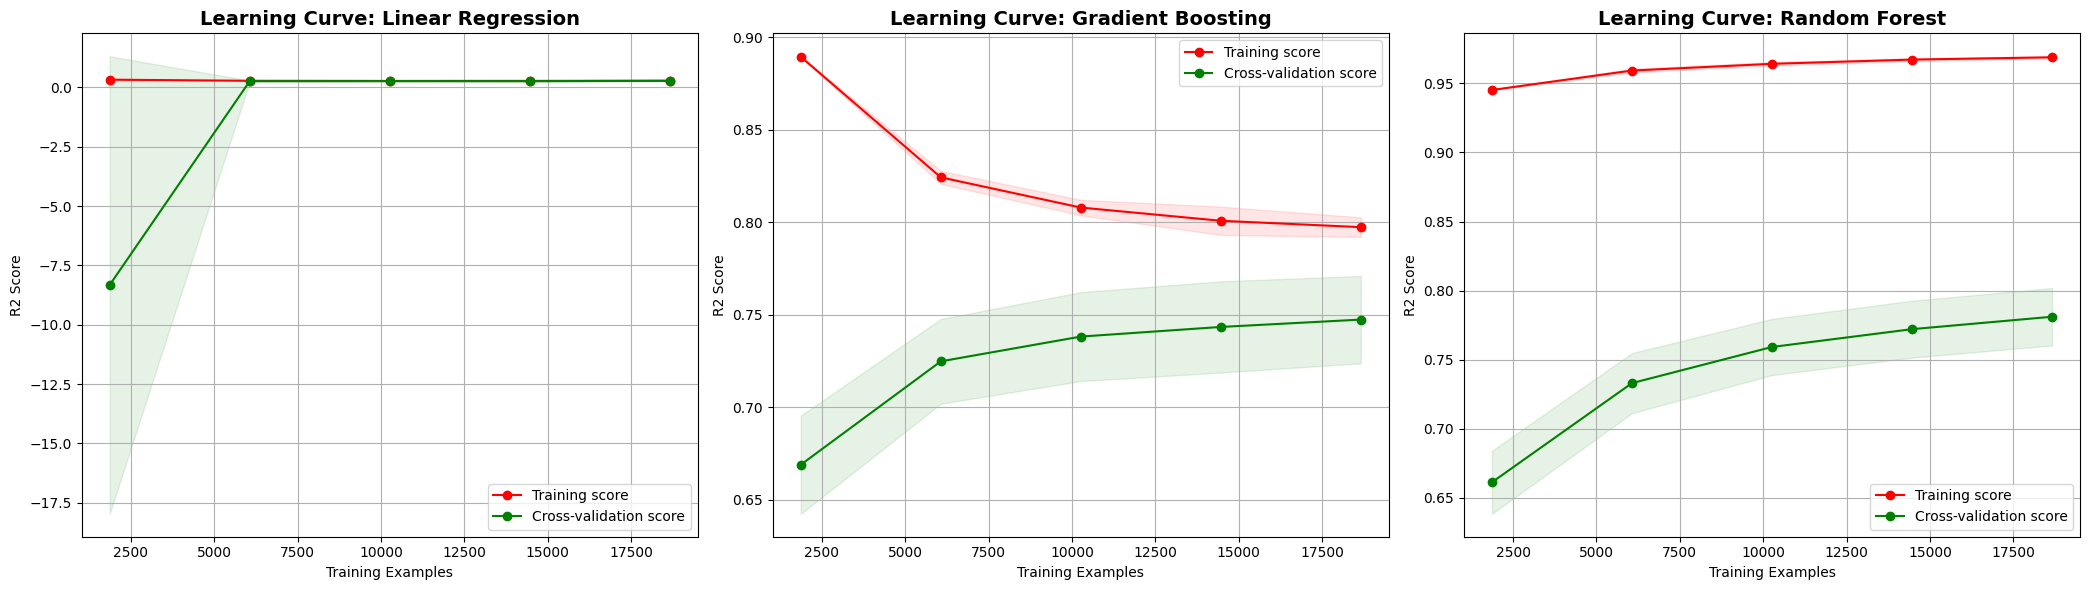

In [ ]:
# =================================================================
# STEP 7: Train โมเดล (เวอร์ชันแทน Ridge ด้วย Gradient Boosting)
# =================================================================

models = {
    "Linear Regression": LinearRegression(),
    "Gradient Boosting": GradientBoostingRegressor(
        n_estimators=400,
        learning_rate=0.05,
        max_depth=3,
        random_state=42
    ),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42)
}

results = []
model_eda_tables = {}

# =========================================================
# TRAIN
# =========================================================
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2_pct = r2_score(y_test, y_pred) * 100

    # Add the results back to the list
    results.append({
        "Model": name,
        "MAE": mae,
        "RMSE": rmse,
        "R2(%)": r2_pct
    })

    model_eda_tables[name] = pd.DataFrame({
        'Actual': y_test,
        'Predicted': y_pred,
        'Error': y_test - y_pred
    })

def plot_learning_curve(models, X, y):
    fig, axes = plt.subplots(1, 3, figsize=(21, 6))

    for i, (name, model) in enumerate(models.items()):
        # คำนวณ Learning Curve
        train_sizes, train_scores, test_scores = learning_curve(
            model, X, y, cv=5, n_jobs=-1,
            train_sizes=np.linspace(0.1, 1.0, 5),
            scoring='r2'
        )

        # หาค่าเฉลี่ยและค่าเบี่ยงเบนมาตรฐาน
        train_mean = np.mean(train_scores, axis=1)
        train_std = np.std(train_scores, axis=1)
        test_mean = np.mean(test_scores, axis=1)
        test_std = np.std(test_scores, axis=1)

        # พล็อตกราฟ
        axes[i].plot(train_sizes, train_mean, 'o-', color="r", label="Training score")
        axes[i].plot(train_sizes, test_mean, 'o-', color="g", label="Cross-validation score")

        # ใส่พื้นที่สีจางแสดงความแปรปรวน (Variance)
        axes[i].fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1, color="r")
        axes[i].fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.1, color="g")

        axes[i].set_title(f"Learning Curve: {name}", fontsize=14, fontweight='bold')
        axes[i].set_xlabel("Training Examples")
        axes[i].set_ylabel("R2 Score")
        axes[i].legend(loc="best")
        axes[i].grid(True)

    plt.tight_layout()
    plt.show()

# เรียกใช้งานฟังก์ชัน
plot_learning_curve(models, X_train, y_train)

# **STEP 8: Evaluate & Compare(ประเมินและเปรียบเทียบประสิทธิภาพของแต่ละโมเดลด้วยค่า MAE, RMSE และ R²)**


📊 STEP 8: MODEL EVALUATION


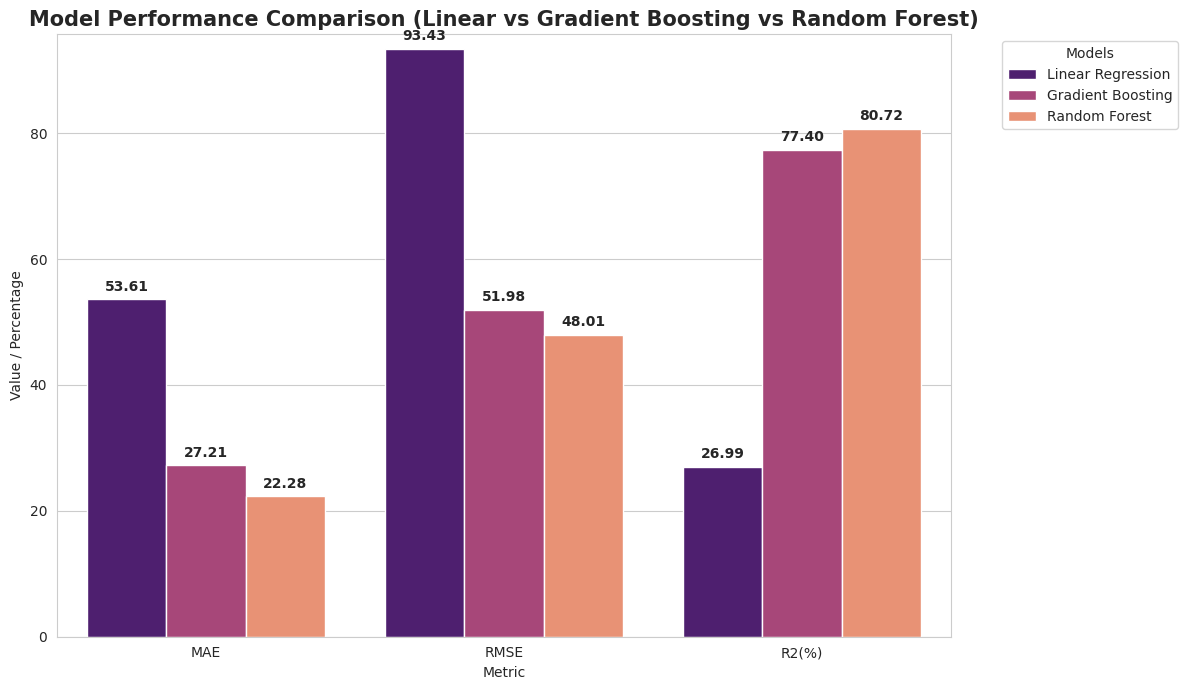


📊 สรุปตารางเปรียบเทียบโมเดล
         Metric Linear Regression Gradient Boosting Random Forest
            MAE             53.61             27.21         22.28
           RMSE             93.43             51.98         48.01
Accuracy (R2 %)            26.99%            77.40%        80.72%


In [ ]:
# =================================================================
# STEP 8: Evaluate & Compare (Linear, Ridge, Random Forest)
# =================================================================

print("\n" + "="*50)
print("📊 STEP 8: MODEL EVALUATION")
print("="*50)

# Create df_res from the results list generated in STEP 7
df_res = pd.DataFrame(results)

# =========================================================
# กราฟเปรียบเทียบประสิทธิภาพ
# =========================================================
plot_data = df_res.melt(id_vars="Model",
                        value_vars=["MAE","RMSE","R2(%)"],
                        var_name="Metric",
                        value_name="Score")

plt.figure(figsize=(12,7))
sns.set_style("whitegrid")

ax = sns.barplot(x='Metric', y='Score', hue='Model', data=plot_data, palette='magma')

for p in ax.patches:
    if p.get_height() > 0:
        ax.annotate(f'{p.get_height():.2f}',
                    (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha = 'center', va = 'center',
                    xytext = (0, 9),
                    textcoords = 'offset points',
                    fontsize=10, fontweight='bold')

plt.title('Model Performance Comparison (Linear vs Gradient Boosting vs Random Forest)', fontsize=15, fontweight='bold')
plt.ylabel('Value / Percentage')
plt.ylim(0, df_res['R2(%)'].max() + 15) # เผื่อที่ด้านบนให้ตัวเลขไม่โดนตัด
plt.legend(title='Models', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# =========================================================
# แสดงตารางเปรียบเทียบแบบข้อความ (ตามรูปแบบที่คุณต้องการ)
# =========================================================

print("\n" + "="*50)
print("📊 สรุปตารางเปรียบเทียบโมเดล")
print("="*50)

# สร้างตารางรูปแบบ Wide format เพื่อให้อ่านง่าย
final_comparison_df = pd.DataFrame({
    'Metric': ['MAE', 'RMSE', 'Accuracy (R2 %)'],
    'Linear Regression': [f"{df_res.loc[0,'MAE']:.2f}", f"{df_res.loc[0,'RMSE']:.2f}", f"{df_res.loc[0,'R2(%)']:.2f}%"],
    'Gradient Boosting': [f"{df_res.loc[1,'MAE']:.2f}", f"{df_res.loc[1,'RMSE']:.2f}", f"{df_res.loc[1,'R2(%)']:.2f}%"],
    'Random Forest': [f"{df_res.loc[2,'MAE']:.2f}", f"{df_res.loc[2,'RMSE']:.2f}", f"{df_res.loc[2,'R2(%)']:.2f}%"]
})

print(final_comparison_df.to_string(index=False))


#**STEP 9: การวิเคราะห์เพิ่มเติมของ Feature importance และ**
#**กราฟทำนายเทียบค่าจริง (Actual vs Predicted)(ของแต่ละ model)**


การวิเคราะห์เพิ่มเติมของ Feature importance


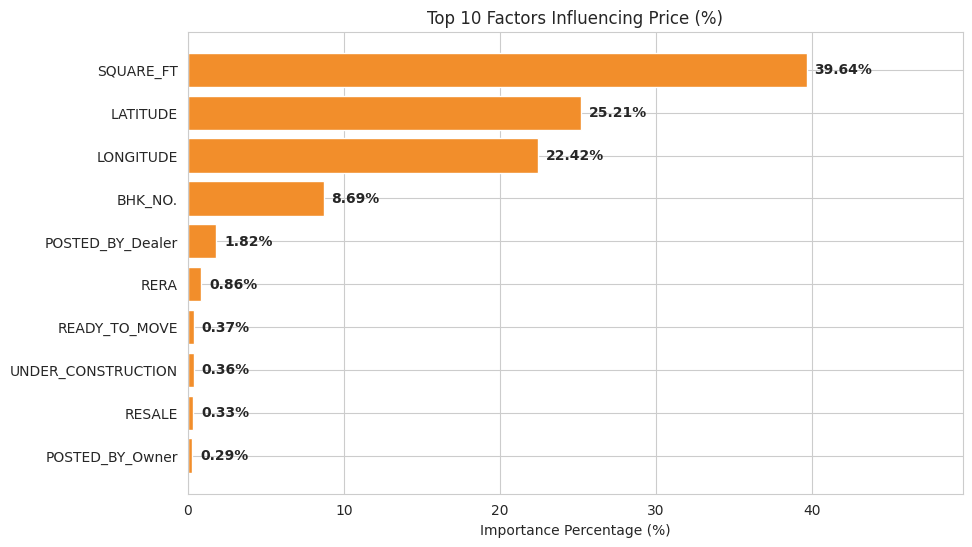


กราฟทำนายเทียบค่าจริง


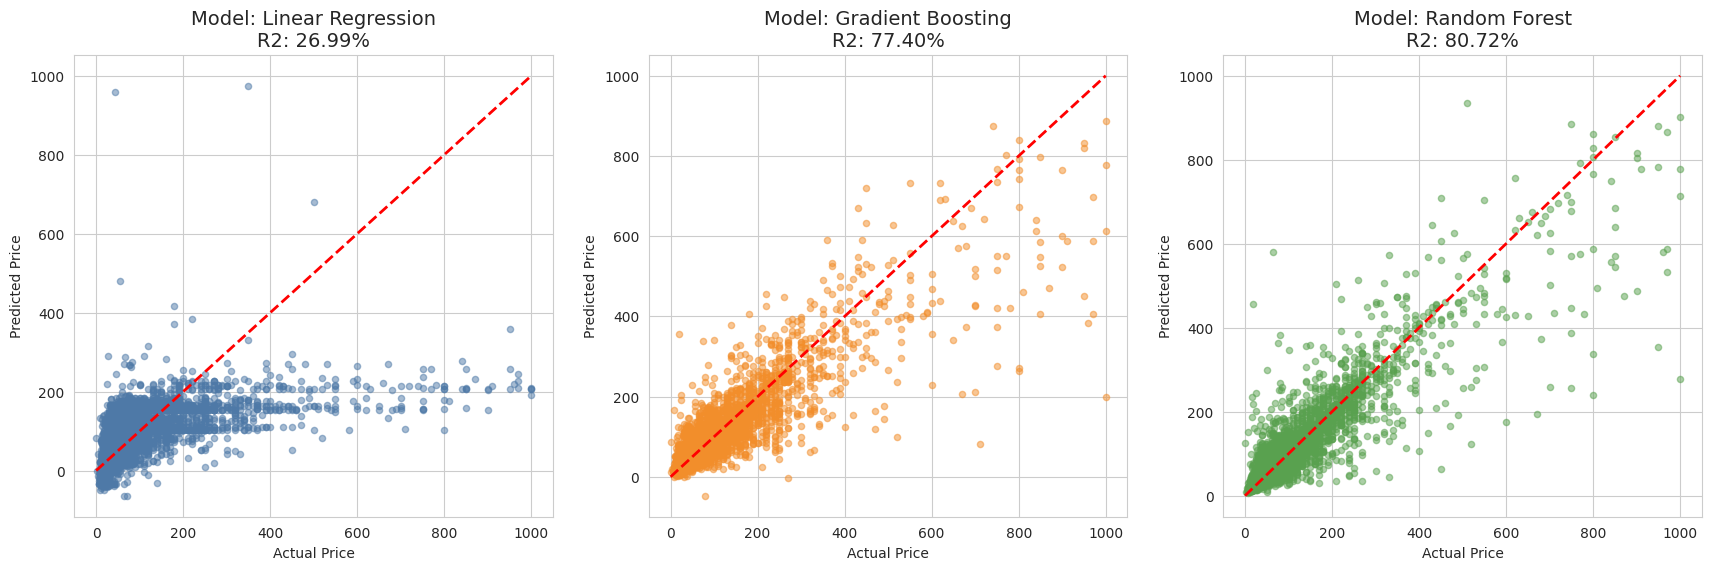

<Figure size 640x480 with 0 Axes>

In [ ]:
# -----------------------------------------------------------------
# STEP 9: การวิเคราะห์เพิ่มเติมของ Feature importance และ กราฟทำนายเทียบค่าจริง
# -----------------------------------------------------------------
print("\n" + "="*50)
print("การวิเคราะห์เพิ่มเติมของ Feature importance")
print("="*50)

# Get the trained Random Forest model from the models dictionary
rf_model = models["Random Forest"]

# คำนวณ Feature Importance เป็น %
importances = pd.Series(rf_model.feature_importances_, index=X.columns) * 100
importances = importances.nlargest(10).sort_values(ascending=True)

# กราฟ Feature Importance พร้อมตัวเลข % กำกับ
plt.figure(figsize=(10, 6))
bars = plt.barh(importances.index, importances.values, color='#f28e2b')

# ใส่ตัวเลข % ที่ปลายแท่ง
for i, v in enumerate(importances.values):
    plt.text(v + 0.5, i, f"{v:.2f}%", va='center', fontweight='bold')

plt.title("Top 10 Factors Influencing Price (%)")
plt.xlabel("Importance Percentage (%)")
plt.xlim(0, max(importances.values) + 10) # เผื่อที่ว่างด้านขวาสำหรับตัวเลข
plt.show()

# กราฟเปรียบเทียบ Actual vs Predicted ระหว่าง 3 โมเดล ---
print("\n" + "="*50)
print("กราฟทำนายเทียบค่าจริง")
print("="*50)
fig, axes = plt.subplots(1, 3, figsize=(21, 6))
model_names = list(models.keys())
colors = ['#4e79a7', '#f28e2b', '#59a14f']

for i, name in enumerate(model_names):
    actual = model_eda_tables[name]['Actual']
    predicted = model_eda_tables[name]['Predicted']
    r2_val = df_res.loc[df_res['Model'] == name, 'R2(%)'].values[0]

    axes[i].scatter(actual, predicted, alpha=0.5, color=colors[i], s=20)

    max_val = max(actual.max(), predicted.max())
    axes[i].plot([0, max_val], [0, max_val], '--r', lw=2)

    axes[i].set_title(f'Model: {name}\nR2: {r2_val:.2f}%', fontsize=14)
    axes[i].set_xlabel('Actual Price')
    axes[i].set_ylabel('Predicted Price')
    axes[i].grid(True)

plt.show()
plt.tight_layout()
plt.show()


# **STEP 10: อธิบายเชิงทฤษฎี(ตีความผลลัพธ์ของโมเดลและเชื่อมโยงกับทฤษฎี Linear Regression, Multiple Regression และ Overfitting)**

In [ ]:
# =================================================================
# STEP 10: สรุปผลการทดลองและตีความเชิงทฤษฎี
# =================================================================

summary_text = f"""
=================================================================
📘 STEP 10: การตีความผลลัพธ์และเชื่อมโยงทฤษฎี (Theoretical Interpretation)
=================================================================

1. การวิเคราะห์ทฤษฎี Linear vs Multiple Regression:
--------------------------------------------------
- ทฤษฎี: ในโปรเจกต์นี้เราใช้ Multiple Regression เนื่องจากราคาบ้าน (Target)
  ถูกพยากรณ์ด้วยปัจจัยหลายตัวแปร (Features) เช่น พื้นที่, จำนวนห้อง และทำเล
- ผลลัพธ์: Linear Regression ให้ค่า R2 ต่ำที่สุด ({df_res.loc[0,'R2(%)']:.2f}%)
  เนื่องจากสมมติฐานเส้นตรง (Linearity) ไม่เพียงพอที่จะอธิบายราคาบ้าน
  ที่มีความซับซ้อนและมีความสัมพันธ์แบบ Non-linear

2. ปัญหา Overfitting และ Underfitting (วิเคราะห์จาก Learning Curve):
--------------------------------------------------
- Linear Regression (Underfitting):
  เกิดอาการ High Bias คือเส้น Training และ Validation ลู่เข้าหากันแต่ได้ Score ต่ำ
  หมายความว่าต่อให้เพิ่มข้อมูลมากกว่านี้ โมเดลก็ไม่สามารถเก่งขึ้นได้เพราะโครงสร้างง่ายเกินไป

- Random Forest & Gradient Boosting (Overfitting Check):
  โมเดลกลุ่มนี้ให้ Score สูงมาก ({df_res.loc[2,'R2(%)']:.2f}%) แต่หากเส้น Training
  สูงกว่า Validation มากเกินไป จะแสดงถึงอาการ High Variance หรือการจดจำ Noise ในข้อมูล
  ทำให้การนำไปใช้กับข้อมูลจริง (Test Set) อาจมีความคลาดเคลื่อนสูงกว่าตอนฝึกสอน

3. ประสิทธิภาพของ Ensemble Learning (แนวคิดกลุ่มต้นไม้):
--------------------------------------------------
- Gradient Boosting และ Random Forest ทำงานได้ดีกว่าอย่างชัดเจน
  เนื่องจากใช้ทฤษฎี "การรวมพลังของตัวแบบ" (Ensemble)
  - Random Forest (Bagging): ช่วยลดความแปรปรวน (Variance) โดยการเฉลี่ยผลจากต้นไม้หลายต้น
  - Gradient Boosting (Boosting): ช่วยลดความผิดพลาด (Bias) โดยให้ต้นไม้ต้นใหม่
    เรียนรู้และแก้ไขจุดที่ต้นไม้ต้นเก่าทำนายผิด

4. สรุปผลจาก Residual Plot:
--------------------------------------------------
- จากกราฟความคลาดเคลื่อน จะเห็นว่าจุดกระจายตัวหนาแน่นรอบเส้น Zero Error
  ในโมเดล Gradient Boosting แสดงถึงความแม่นยำสูงสุด แต่ในบ้านที่มี "ราคาสูงผิดปกติ"
  ทุกโมเดลมักจะมี Error สูงขึ้นตามทฤษฎี Long-tail Distribution
  (ข้อมูลราคาสูงมีจำนวนน้อย ทำให้โมเดลเรียนรู้ได้ไม่ครอบคลุม)

-----------------------------------------------------------------
💡 บทสรุป: โมเดลที่ดีที่สุดคือ {df_res.sort_values(by='R2(%)', ascending=False).iloc[0]['Model']}
ที่มีความสามารถในการเรียนรู้รูปแบบข้อมูลที่ซับซ้อนได้ดีที่สุดในชุดข้อมูลนี้
-----------------------------------------------------------------
"""

print(summary_text)


📘 STEP 10: การตีความผลลัพธ์และเชื่อมโยงทฤษฎี (Theoretical Interpretation)

1. การวิเคราะห์ทฤษฎี Linear vs Multiple Regression:
--------------------------------------------------
- ทฤษฎี: ในโปรเจกต์นี้เราใช้ Multiple Regression เนื่องจากราคาบ้าน (Target)
  ถูกพยากรณ์ด้วยปัจจัยหลายตัวแปร (Features) เช่น พื้นที่, จำนวนห้อง และทำเล
- ผลลัพธ์: Linear Regression ให้ค่า R2 ต่ำที่สุด (26.99%)
  เนื่องจากสมมติฐานเส้นตรง (Linearity) ไม่เพียงพอที่จะอธิบายราคาบ้าน
  ที่มีความซับซ้อนและมีความสัมพันธ์แบบ Non-linear

2. ปัญหา Overfitting และ Underfitting (วิเคราะห์จาก Learning Curve):
--------------------------------------------------
- Linear Regression (Underfitting):
  เกิดอาการ High Bias คือเส้น Training และ Validation ลู่เข้าหากันแต่ได้ Score ต่ำ
  หมายความว่าต่อให้เพิ่มข้อมูลมากกว่านี้ โมเดลก็ไม่สามารถเก่งขึ้นได้เพราะโครงสร้างง่ายเกินไป

- Random Forest & Gradient Boosting (Overfitting Check):
  โมเดลกลุ่มนี้ให้ Score สูงมาก (80.72%) แต่หากเส้น Training
  สูงกว่า Validation มากเกินไป จะแสดงถึง

In [ ]:
# -----------------------------------------------------------------
# 3.1 ผลการวิเคราะห์ข้อมูล
# -----------------------------------------------------------------
print("\n" + "="*50)
print("📊 3.1 ตารางสถิติพรรณนาหลังทำความสะอาด")
print("="*50)

# แสดงตารางสถิติ
stats_summary = df_cleaned[[target_col, 'SQUARE_FT', 'BHK_NO.']].describe()
print("\n[ตารางสถิติพรรณนาหลังทำความสะอาด]")
print(stats_summary.round(2))

# กราฟ EDA (เหลือเฉพาะ Histogram)
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))



📊 3.1 ตารางสถิติพรรณนาหลังทำความสะอาด

[ตารางสถิติพรรณนาหลังทำความสะอาด]
       TARGET(PRICE_IN_LACS)   SQUARE_FT   BHK_NO.
count               29156.00    29156.00  29156.00
mean                   92.93     1570.63      2.38
std                   105.11    26396.65      0.86
min                     0.25        3.00      1.00
25%                    37.50      899.96      2.00
50%                    60.50     1170.05      2.00
75%                   100.00     1537.27      3.00
max                  1040.00  4300000.00     20.00


<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

In [ ]:
# -----------------------------------------------------------------
# 3.2 วิเคราะห์สาเหตุการทำนายผิดพลาดเชิงลึก
# -----------------------------------------------------------------

# 1. เตรียม DataFrame สำหรับวิเคราะห์ (ใช้ผลจากโมเดลที่แม่นยำที่สุด เช่น Gradient Boosting)
best_model_name = "Gradient Boosting"
y_pred_best = model_eda_tables[best_model_name]['Predicted']

analysis_df = pd.DataFrame({
    'Actual_Price': y_test,
    'Predicted': y_pred_best,
    'Error_Amount': abs(y_test - y_pred_best),
    'Error_Percentage': (abs(y_test - y_pred_best) / y_test) * 100
})

# แสดงตัวอย่าง 5 อันดับที่พลาดที่สุด (Error มากที่สุด)
worst_5 = analysis_df.sort_values(by='Error_Amount', ascending=False).head(5)

print("\n" + "="*65)
print(f"📌 กรณีศึกษาตัวอย่างที่ทำนายผิด ")
print("="*65)

print("\n[ตารางแสดงเคสที่ทำนายคลาดเคลื่อนสูงสุด 5 อันดับแรก]")
print(worst_5.round(2).to_string())

print("\n" + "-"*65)
print("🔍 วิเคราะห์กรณีศึกษาตัวอย่างที่ทำนายผิดพลาดสูงสุด (Error Analysis)")
print("-"*65)

# อธิบายกลุ่ม Underestimation
print("\n1. กลุ่มความผิดพลาดแบบ 'พยากรณ์ต่ำเกินจริงรุนแรง' (Extreme Underestimation)")
print("   - ตัวอย่าง ID 12533 : ราคาจริง 1000.0 แต่โมเดลทำนายเพียง 199.92 (Error 80.01%)")
print("   - ตัวอย่าง ID 17376 : ราคาจริง 710.0 แต่ทำนายเพียง 83.01 (Error 88.31%)'")
print("   - วิเคราะห์ : โมเดลมีแนวโน้มดึงค่าทำนายกลับเข้าสู่ค่าเฉลี่ย (Regression to the Mean)")
print("   - สาเหตุ: กลุ่มราคาสูงมีจำนวนข้อมูลน้อยใน Dataset ทำให้โมเดลไม่สามารถเรียนรู้รูปแบบของทรัพย์สิน")
print("     ระดับสูงได้เพียงพอ ส่งผลให้ทำนายต่ำกว่าความเป็นจริงอย่างมาก")

# อธิบายกลุ่ม High-Value Segment Bias
print("\n2. กลุ่มราคาสูงในช่วง 800–1000 ที่ถูกประเมินต่ำ (High-Value Segment Bias)")
print("   - ตัวอย่าง ID 9270 : ราคาจริง 960.0 แต่ทำนาย 383.63 (Error 60.04%)")
print("   - ตัวอย่าง ID 29084 : ราคาจริง 970.0 แต่ทำนาย 405.45 (Error 58.20%)")
print("   - ตัวอย่าง ID 16264 : ราคาจริง 800.0 แต่ทำนาย 264.33 (Error 66.96%)")
print("   - วิเคราะห์ : ข้อมูลมีการกระจายแบบหางยาว (Right-Skewed / Long Tail Distribution)")
print("   - สาเหตุ: Dataset ส่วนใหญ่อยู่ในช่วงราคาปานกลาง ทำให้โมเดลเรียนรู้โครงสร้างหลักจากกลุ่มนั้นเป็นหลัก")
print("     เมื่อพบราคาสูงจึงประเมินต่ำกว่าความจริงเพื่อลดความผิดพลาดรวม (Overall Loss)")

# อธิบายSystematic Pattern
print("\n3. แนวโน้มเชิงระบบ (Systematic Pattern)")
print("   - ทั้ง 5 กรณีเป็นการทำนายต่ำทั้งหมด (Predicted < Actual)")
print("   - ทั้ง 5 กรณีเป็นการทำนายต่ำทั้งหมด (Predicted < Actual)")
print("   - อาจเกิดจากการ Normalize/Scaling หรือการตั้งค่า Hyperparameter ที่ทำให้โมเดลมีความ Conservative สูงเกินไป")

print("\n" + "="*65)
print("💡 สรุปเพื่อการนำเสนอในบทที่ 3:")
print(f"    ความผิดพลาดสูงสุดที่พบไม่ได้เกิดจากการทำงานผิดปกติของโมเดล แต่เกิดจากโครงสร้างข้อมูลที่ไม่สมดุล")
print("และจำนวนตัวอย่างในกลุ่มราคาสูงมีจำกัด ทำให้โมเดลไม่สามารถ Generalize กับกลุ่ม Luxury/High-Value")
print("ได้ดีพอ จึงเกิดการประเมินค่าต่ำกว่าความเป็นจริงอย่างเป็นระบบ")
print("="*65)


📌 กรณีศึกษาตัวอย่างที่ทำนายผิด 

[ตารางแสดงเคสที่ทำนายคลาดเคลื่อนสูงสุด 5 อันดับแรก]
       Actual_Price  Predicted  Error_Amount  Error_Percentage
12533        1000.0     199.92        800.08             80.01
17376         710.0      83.01        626.99             88.31
9270          960.0     383.63        576.37             60.04
29084         970.0     405.45        564.55             58.20
16264         800.0     264.33        535.67             66.96

-----------------------------------------------------------------
🔍 วิเคราะห์กรณีศึกษาตัวอย่างที่ทำนายผิดพลาดสูงสุด (Error Analysis)
-----------------------------------------------------------------

1. กลุ่มความผิดพลาดแบบ 'พยากรณ์ต่ำเกินจริงรุนแรง' (Extreme Underestimation)
   - ตัวอย่าง ID 12533 : ราคาจริง 1000.0 แต่โมเดลทำนายเพียง 199.92 (Error 80.01%)
   - ตัวอย่าง ID 17376 : ราคาจริง 710.0 แต่ทำนายเพียง 83.01 (Error 88.31%)'
   - วิเคราะห์ : โมเดลมีแนวโน้มดึงค่าทำนายกลับเข้าสู่ค่าเฉลี่ย (Regression to the Mean)
   - สาเหตุ: 